<a href="https://colab.research.google.com/github/sAndreotti/MedicalMeadow/blob/main/ATML_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MedicalMeadow ChatBot fine-tuning Llama 3.2 1B
MedicalMeadow is a project focused on training a chatbot using the LLaMA model, fine-tuned with the Medical Meadow dataset. The aim is to develop a robust NLP system capable of answering medical questions effectively.

## Libraries

### Download

In [5]:
!pip install datasets accelerate peft transformers trl==0.12.0 plotly huggingface_hub
!pip install --upgrade smart_open
!pip install --upgrade gensim
!pip install ffmpeg-python
!pip install -U openai-whisper
!pip install scipy librosa unidecode inflect
!pip install unsloth
!pip uninstall unsloth -y && pip install --upgrade --no-cache-dir --no-deps git+https://github.com/unslothai/unsloth.git
!pip install TTS
!pip uninstall -y bitsandbytes
!pip install bitsandbytes
!pip install nltk
!pip install python-dotenv

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Found existing installation: unsloth 2025.1.5
Uninstalling unsloth-2025.1.5:
  Successfully uninstalled unsloth-2025.1.5
  Cloning https://github.com/unslothai/unsloth.git to /tmp/pip-req-build-6e8o6bet
  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth.git /tmp/pip-req-build-6e8o6bet
  Resolved https://github.com/unslothai/unsloth.git to commit 5dddf27f3ba94506c48251e907031039eecd40d1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for unsloth: filename=unsloth-2025.1.5-py3-none-any.whl size=176838 sha256=b4e74c1f947e01d29d98c46e65298c5e92c88b7fc2f57550471e8edd8db5398f
  Stored in directory: /tmp/pip-ephem-wheel-cache-1a5m49j0/wheels/ed/d4/e9/76fb290ee3df0a5fc21ce5c2c788e29e9607a2353d8342fd0d
Successfully built unsloth
Found existing installation: bitsandbytes 0.45.0
Uninstalling bitsandbytes-0.45.0:
  Successfully uninstalled bitsandbytes-0.4

### Import

In [6]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from trl import SFTTrainer
import re
from gensim.models.word2vec import Word2Vec
import plotly.express as px
import random
from sklearn.manifold import TSNE
from torch.utils.data import Dataset
from torch.utils.data import random_split
from torch.utils.data import Subset
from peft import prepare_model_for_kbit_training, LoraConfig
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    TrainingArguments,
    DataCollatorForSeq2Seq,
    AutoModelForSpeechSeq2Seq,
    AutoProcessor,
    pipeline,
    TextStreamer
)
from peft import AutoPeftModelForCausalLM
import pandas as pd
from wordcloud import WordCloud
import nltk
from nltk.translate.bleu_score import sentence_bleu
from tabulate import tabulate

from unsloth import FastLanguageModel
from unsloth.chat_templates import get_chat_template
from unsloth.chat_templates import train_on_responses_only
from TTS.api import TTS
from dotenv import load_dotenv
from huggingface_hub import login
import os

### Import for audio section

In [7]:
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg
import scipy
import whisper

import librosa
import soundfile as sf

## Hugging Face settings

In order to carry out operations with Llama and to have authorisations to use it, it is necessary to log in to Hugging Face and make a request to use the template. The HF access token must be saved in an .env file

In [8]:
load_dotenv()
login(token=os.environ.get('HF_TOKEN'))

## Investigate Dataset

This dataset, [Medical Meadow](https://huggingface.co/datasets/medalpaca/medical_meadow_medical_flashcards?row=0), includes a deep understanding of basic medical sciences, clinical knowledge, and clinical skills. The embedded flashcards are created and updated by medical students and cover the entirety of this curriculum, addressing subjects such as anatomy, physiology, pathology, pharmacology, and more. These flashcards frequently feature succinct summaries and mnemonics to aid in learning and retention of vital medical concepts.

In this section, we analyse the dataset under consideration

In [9]:
# Download Medical Meadow dataset from HF
ds = load_dataset("medalpaca/medical_meadow_medical_flashcards")

# The dataset is composed by just on split: 'train'
ds = ds['train']
ds

README.md:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

(…)l_meadow_wikidoc_medical_flashcards.json:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/33955 [00:00<?, ? examples/s]

Dataset({
    features: ['input', 'output', 'instruction'],
    num_rows: 33955
})

In [18]:
# Analyze the dataset: input, output, instruction
print(ds.features, "\n")
print("Instruction:")
print(f"length: {len(ds['instruction'])}")
print(f"example: {ds['instruction'][0]} \n")

print(f"Input:")
print(f"length: {len(ds['input'])}")
print(f"example: {ds['input'][0]} \n")

print(f"Output:")
print(f"length: {len(ds['output'])}")
print(f"example: {ds['output'][0]} \n")

### Some plots about the dataset

In [12]:
# Better usability
instructions = ds['instruction']
input_phrases = ds['input']
output_phrases = ds['output']

Plot about the ditribution of instruction's classes (just 1 class for all instances)

In [13]:
%matplotlib inline

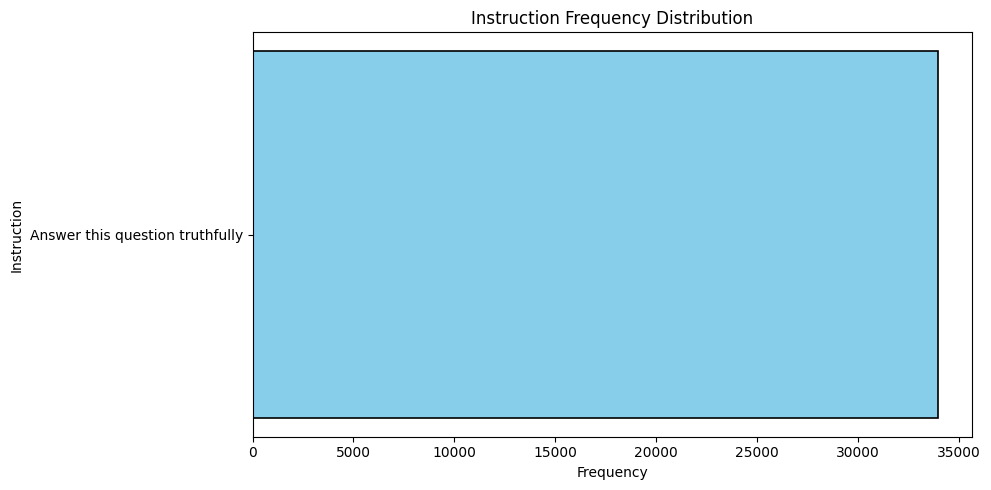

In [14]:
# Count the frequency of each unique instruction
instruction_counts = {instruction: instructions.count(instruction) for instruction in set(instructions)}

# Sort the instructions by frequency
sorted_instructions = sorted(instruction_counts.items(), key=lambda x: x[1], reverse=True)

# Separate the instructions and their counts for plotting
sorted_instruction_names = [item[0] for item in sorted_instructions]
sorted_instruction_counts = [item[1] for item in sorted_instructions]

# Plotting the frequency of instructions
plt.figure(figsize=(10, 5))

bars = plt.barh(sorted_instruction_names, sorted_instruction_counts, color='skyblue', edgecolor='black', linewidth=1.2)
plt.title('Instruction Frequency Distribution')
plt.xlabel('Frequency')
plt.ylabel('Instruction')

# Show the plot
plt.tight_layout()
plt.savefig("instruction_frequency_distribution.png")
plt.show()

Two plots about the distribution of the lengths of the instances of the input and output sentences

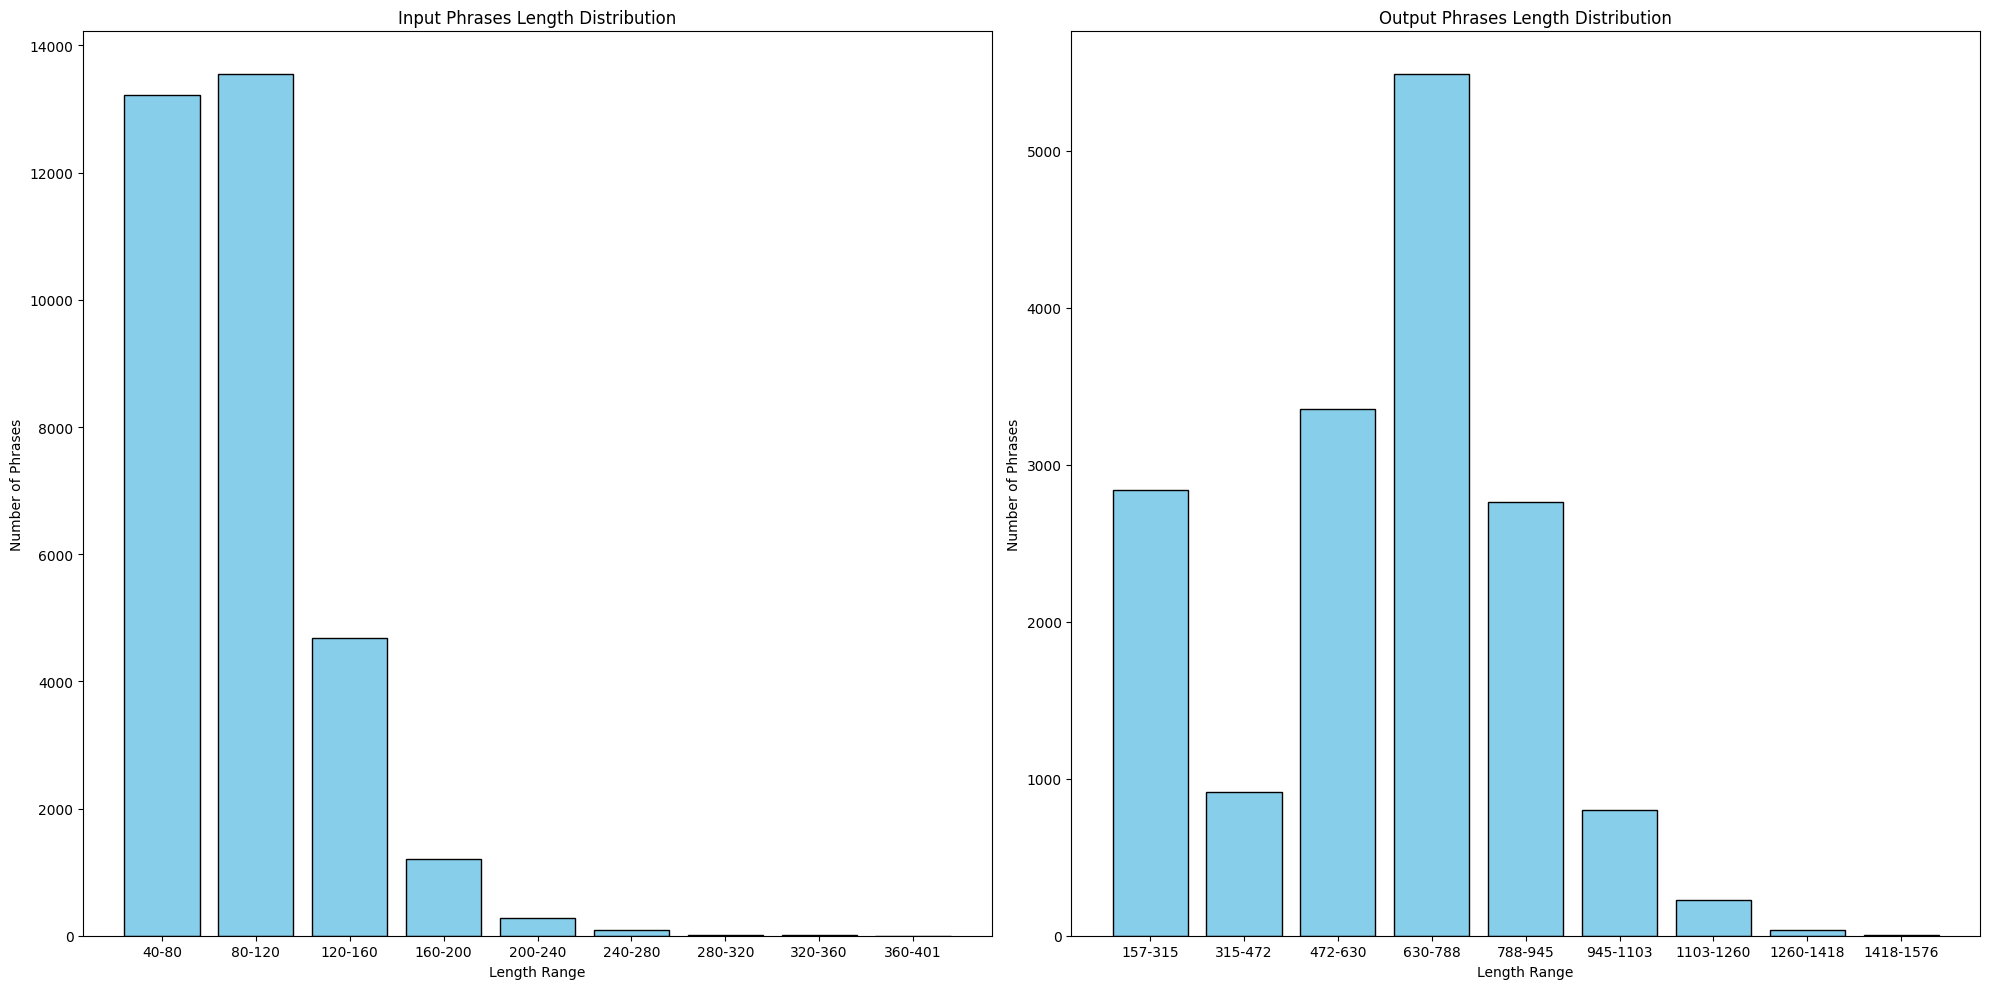

In [19]:
# Calculate the length of each phrase
input_lengths = [len(phrase) for phrase in input_phrases]
output_lengths = [len(phrase) for phrase in output_phrases]

# Define the bins for the length ranges
max_input = max(input_lengths)
max_output = max(output_lengths)

input_bins = [i * max_input / 10 for i in range(1, 11)]
output_bins = [i * max_output / 10 for i in range(1, 11)]
bin_labels_input = [f'{int(input_bins[i-1])}-{int(input_bins[i])}' for i in range(1, 10)]
bin_labels_output = [f'{int(output_bins[i-1])}-{int(output_bins[i])}' for i in range(1, 10)]

# Bin the lengths into the categories
input_binned = np.digitize(input_lengths, input_bins)  # Categorize based on input lengths
output_binned = np.digitize(output_lengths, output_bins)  # Categorize based on output lengths

# Count how many phrases fall into each bin
input_bin_counts = [sum(input_binned == i) for i in range(1, len(input_bins))]
output_bin_counts = [sum(output_binned == i) for i in range(1, len(output_bins))]

# Plotting the bar charts
plt.figure(figsize=(20, 10))

# Plotting the input phrase lengths
plt.subplot(1, 2, 1)
plt.bar(bin_labels_input, input_bin_counts, color='skyblue', edgecolor='black')
plt.title('Input Phrases Length Distribution')
plt.xlabel('Length Range')
plt.ylabel('Number of Phrases')

# Plotting the output phrase lengths
plt.subplot(1, 2, 2)
plt.bar(bin_labels_output, output_bin_counts, color='skyblue', edgecolor='black')
plt.title('Output Phrases Length Distribution')
plt.xlabel('Length Range')
plt.ylabel('Number of Phrases')

# Show the plots
plt.tight_layout()
plt.savefig("sentences_length.png")
plt.show()

### Extra Plot
WordCloud to show the most frequent words in input and output set


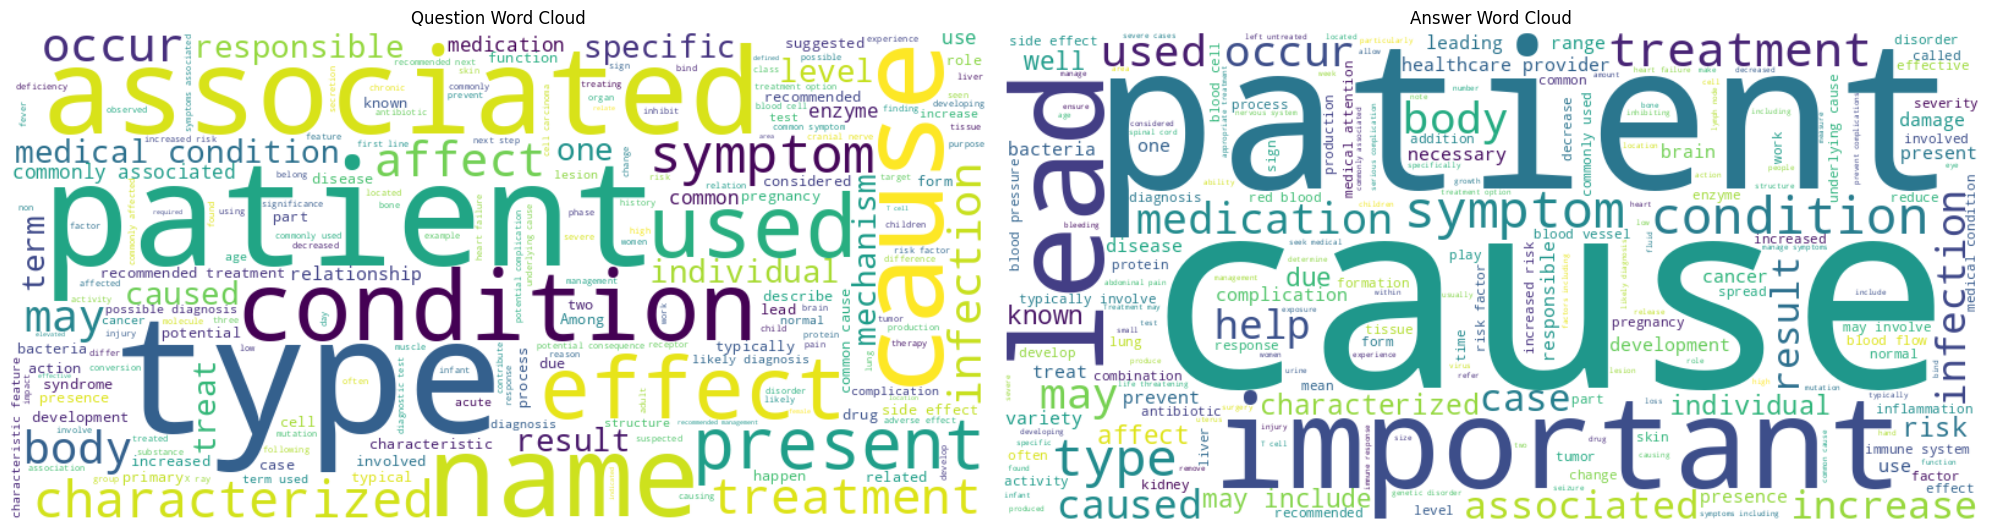

In [20]:
# Join together all words from input set
input = ' '.join(input_phrases)

# Join together all words from output set
output = ' '.join(output_phrases)

# Instantiate WC for input and for output
wordcloud1 = WordCloud(width=800, height=400, background_color='white').generate(input)
wordcloud2 = WordCloud(width=800, height=400, background_color='white').generate(output)

# Plotting the bar charts
plt.figure(figsize=(20, 10))

# Plotting the input words
plt.subplot(1, 2, 1)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis('off')
plt.title('Question Word Cloud')

# Plotting the output words
plt.subplot(1, 2, 2)
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis('off')
plt.title('Answer Word Cloud')

# Show
plt.tight_layout()
plt.savefig("question_word_cloud.png")
plt.show()

## Word2Vec

Word2Vec transforms the words in the dataset into numerical vectors based on the context in which they appear in the text, creating dense word representations that capture their semantic and syntactic relationships. In this notebook, we are using it to analyze the words in the dataset and generate graphs that visualize the relationships and similarities between words, providing a visual representation of the linguistic connections within the corpus.

In [22]:
# Tokenize with spaces or any non word character
tokenized_sentences = [re.sub('\W', ' ', sentence).lower().split() for sentence in input_phrases]

# remove sentences that are only 1 word long
tokenized_sentences = [sentence for sentence in tokenized_sentences if len(sentence) > 1]

for sentence in tokenized_sentences[:5]:
    print(sentence)

In [23]:
# Create Word2Vec (ignore words with frequency less than 5)
WordModel = Word2Vec(tokenized_sentences, vector_size=30, min_count=5, window=10)

In [24]:
sample = random.sample(list(WordModel.wv.key_to_index), 500)
word_vectors = WordModel.wv[sample]

### 3D plot with words

Now we use [t-SNE](https://www.datacamp.com/tutorial/introduction-t-sne) (t-distributed Stochastic Neighbor Embedding) for data exploration and visualizing high-dimensional data.

Visualize a plot with dataset words' in the 3D space

In [26]:
# Apply t-SNE to word vectors
tsne = TSNE(n_components=3, n_iter=2000)
tsne_embedding = tsne.fit_transform(word_vectors)

# Extract individual dimensions
x, y, z = np.transpose(tsne_embedding)

# Create 3D scatter plot with a subset of the dataset
fig = px.scatter_3d(x=x[:200],y=y[:200],z=z[:200],text=sample[:200])
# Full dataset
# fig = px.scatter_3d(x=x,y=y,z=z,text=sample)
fig.update_traces(marker=dict(size=3,line=dict(width=2)),textfont_size=10)
fig.show()

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



Here's a question of the dataset: "What is the relationship between very low Mg2+ levels, PTH levels, and Ca2+ levels?" now we want to see if Mg2 and Ca2 are close in the 3D space.

In [27]:
first_question = ['mg2', 'ca2']

word_vectors = WordModel.wv[first_question+sample]

tsne = TSNE(n_components=3)
tsne_embedding = tsne.fit_transform(word_vectors)

x, y, z = np.transpose(tsne_embedding)

In [29]:
r = (-30,30)
fig = px.scatter_3d(x=x, y=y, z=z, range_x=r, range_y=r, range_z=r, text=first_question + [None] * 500)
fig.update_traces(marker=dict(size=3,line=dict(width=2)),textfont_size=10)
fig.show()

In [30]:
# Use Word2Vec to find most similar words
WordModel.wv.most_similar('ca2')

[('k', 0.9605814814567566),
 ('na', 0.9589905142784119),
 ('activity', 0.9500560760498047),
 ('adh', 0.9471959471702576),
 ('permeability', 0.9467471241950989),
 ('adrenergic', 0.944303572177887),
 ('aldosterone', 0.9402572512626648),
 ('concentration', 0.9381481409072876),
 ('renin', 0.9374908804893494),
 ('stimulation', 0.9373416900634766)]

In [34]:
# Example of King – Man + Woman = Queen 
vec = WordModel.wv.get_vector('headache') + (WordModel.wv.get_vector('fever') - WordModel.wv.get_vector('drug'))
WordModel.wv.similar_by_vector(vec)

[('pain', 0.9017053246498108),
 ('abdominal', 0.871136486530304),
 ('chest', 0.8555678129196167),
 ('fever', 0.8440346717834473),
 ('loss', 0.8315027952194214),
 ('shortness', 0.8294406533241272),
 ('presenting', 0.8202990889549255),
 ('onset', 0.8153195977210999),
 ('bilateral', 0.8146665692329407),
 ('leukocytosis', 0.8145710229873657)]

## Dataset Class

We create a `MedDataset` class to ensure consistency between the format of the MedicalMeadow dataset and how it will be used during the training process with roles supported by Llama [text models](https://www.llama.com/docs/model-cards-and-prompt-formats/llama3_2).

In [35]:
class MedDataset(Dataset):
    def __init__(self, dataset, tokenizer):
        self.dataset = dataset
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        example = self.dataset[idx]
        
        # Construct a conversation-style prompt with instruction, input, and output
        messages = [
            {"role": "system", "content": example['instruction']},  # Starting instruction
            {"role": "user", "content": example['input']},  # Input provided by the user
            {"role": "assistant", "content": example['output']}  # Expected output from the assistant
        ]

        # Create a prompt using the tokenizer's chat template
        prompt = self.tokenizer.apply_chat_template(
            messages,
            tokenize=False,  # The prompt remains untokenized for now
            add_generation_prompt=True  # Add any required generation-specific tokens
        )

        # Tokenize the prompt into a format suitable for model input
        tokens = self.tokenizer(
            prompt,
            padding="max_length",  # Pad sequences to a fixed maximum length
            truncation=True,  # Truncate sequences that exceed the maximum length
            max_length=128,  # Set the maximum sequence length
            return_tensors="pt" 
        )

        tokens['labels'] = tokens['input_ids'].clone()
        # Mask padding tokens in the labels to ignore them during loss computation
        tokens['labels'][tokens['input_ids'] == self.tokenizer.pad_token_id] = -100

        return {
            "input_ids": tokens['input_ids'].squeeze(),  # Tokenized input sequence
            "attention_mask": tokens['attention_mask'].squeeze(),  # Attention mask for the input
            "labels": tokens['labels'].squeeze()  # Labels for the model to predict
        }

In [36]:
# Split dataset
train_set, val_set, test_dataset = random_split(ds, [0.8, 0.1, 0.1])

## Model Creation
This section imports and sets the model to be fine-tuned

### Load [Llama 3.2 1B Instruct](https://huggingface.co/meta-llama/Llama-3.2-1B-Instruct)
The model chosen to be fine-tuned is Llama, specifically version 3.2 which has a variant with only 1B parameters and is optimized for chat-style question answering (Instruct)

In [37]:
# Base model from Hugging Face
base_model = "meta-llama/Llama-3.2-1B-Instruct"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(base_model)
tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

We only initialize the dataset class for train and validation now since we needed the tokenizer, which is useful to apply the template for chat. While for the testset we are going to use a different template.

In [38]:
# Create datasets for training and validation
train_dataset = MedDataset(train_set, tokenizer)
val_dataset = MedDataset(val_set, tokenizer)

# Print dataset dimensions
print(f"Train dataset dimension: {len(train_dataset)}")
print(f"Validation dataset dimension: {len(val_dataset)}")
print(f"Test dataset dimension: {len(test_dataset)}")

In the next cell we configured BitsandBytes, to apply 4-bit quantization.
 It allows us to reduce the precision of the numbers used to represent the model weights, saving memory space and improving the speed of inference

In [39]:
# Set dtype for quantization
compute_dtype = getattr(torch, "float16")

# Set quantization config for BitsAndBytes
quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=False,
    bnb_4bit_representation="nested"
)

We load the model from Hugging Face

In [40]:
# Load LLAMA model with quantization
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    quantization_config=quant_config,
    device_map={"": 0},
    torch_dtype=torch.float32,
    trust_remote_code=True
)
model.config.use_cache = False
model.config.pretraining_tp = 1

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

config.json:   0%|          | 0.00/877 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

## Model training

Relative to training, in order to minimize the fine-tuning time and without having to retrain all model parameters, we used the PEFT technique, to update only a small part of parameters useful for the task

In [42]:
peft_params = LoraConfig(
    lora_alpha=32,  # Scaling factor for the LoRA updates to control the adaptation strength
    lora_dropout=0.1, 
    r=16,  # Rank of the low-rank adaptation matrices; smaller values reduce the number of trainable parameters
    bias="none",
    task_type="CAUSAL_LM",  # Causal language modeling task
)

In [43]:
model.train()

# Define training parameters using the TrainingArguments class
training_params = TrainingArguments(
    output_dir="./results",  # Directory to save model checkpoints and training outputs
    num_train_epochs=1,
    per_device_train_batch_size=8,  # Batch size for each device during training
    gradient_accumulation_steps=4,  # Number of steps to accumulate gradients before updating weights
    optim="paged_adamw_32bit",
    eval_strategy="steps",  # Evaluation frequency is defined by the number of steps
    logging_steps=90,
    eval_steps=90,
    learning_rate=2e-4,  
    weight_decay=0.001,  # Weight decay factor for regularization to prevent overfitting
    fp16=False,  # Disable 16-bit floating-point precision for training
    bf16=False,  # Disable bfloat16 precision for training
    max_grad_norm=0.3,  # Maximum gradient norm for gradient clipping
    max_steps=-1,  # Total number of training steps (-1 means determined by epochs)
    warmup_ratio=0.03,  # Fraction of steps for learning rate warmup
    group_by_length=True,  # Group samples of similar lengths for more efficient training
    lr_scheduler_type="constant", 
    gradient_checkpointing=True  # Enable gradient checkpointing to save memory
)

For fine-tuning we use Supervised Fine-Tuning Trainer, passing the parameters set previously

In [44]:
trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    peft_config=peft_params,
    max_seq_length=256,
    tokenizer=tokenizer,
    args=training_params,
    packing=False,
)

# Train the model
# trainer.train()

# Save the model and tokenizer
# trainer.save_model("./fine-tuned-model")
# tokenizer.save_pretrained("./fine-tuned-model")

### Plots

In [ ]:
df = pd.DataFrame(trainer.state.log_history)

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(df['loss'], label='Training Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.savefig("training_and_validation_loss.png")
plt.show()

### 0-shot fine tuning

In [45]:
# Define the model for 0-shot
model0 = AutoModelForCausalLM.from_pretrained(
    base_model,
    quantization_config=quant_config,
    device_map={"": 0},
    torch_dtype=torch.float16,
    trust_remote_code=True
)
model0.config.use_cache = False
model0.config.pretraining_tp = 1

### Few-shot fine tuning

In [57]:
# Prepare the dataset for few-shot fine tuning (just 5 instances)
subset = Subset(ds, list(range(5)))

few_dataset = MedDataset(subset, tokenizer)
few_dataset

In [60]:
# Define the model
modelFEW = AutoModelForCausalLM.from_pretrained(
    base_model,
    quantization_config=quant_config,
    device_map={"": 0},
    torch_dtype=torch.float16,
    trust_remote_code=True
)
modelFEW.config.use_cache = False
modelFEW.config.pretraining_tp = 1

training_params = TrainingArguments(
    output_dir="./results",  # Directory to save model checkpoints and training outputs
    num_train_epochs=1,
    per_device_train_batch_size=8,  # Batch size for each device during training
    gradient_accumulation_steps=4,  # Number of steps to accumulate gradients before updating weights
    optim="paged_adamw_32bit",
    logging_steps=90,
    learning_rate=2e-4,  
    weight_decay=0.001,  # Weight decay factor for regularization to prevent overfitting
    fp16=False,  # Disable 16-bit floating-point precision for training
    bf16=False,  # Disable bfloat16 precision for training
    max_grad_norm=0.3,  # Maximum gradient norm for gradient clipping
    max_steps=-1,  # Total number of training steps (-1 means determined by epochs)
    warmup_ratio=0.03,  # Fraction of steps for learning rate warmup
    group_by_length=True,  # Group samples of similar lengths for more efficient training
    lr_scheduler_type="constant", 
    gradient_checkpointing=True,  # Enable gradient checkpointing to save memory
    report_to="none",
)

trainer = SFTTrainer(
    model=modelFEW,
    train_dataset=few_dataset,
    peft_config=peft_params,
    max_seq_length=256,
    tokenizer=tokenizer,
    args=training_params,
    packing=False,
)
# Few shot training
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning:

`torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.



Step,Training Loss


TrainOutput(global_step=1, training_loss=4.0770721435546875, metrics={'train_runtime': 1.9942, 'train_samples_per_second': 2.507, 'train_steps_per_second': 0.501, 'total_flos': 3743424184320.0, 'train_loss': 4.0770721435546875, 'epoch': 1.0})

In [67]:
def inference(question, model_inf, tokenizer_inf):
    messages = [{"role": "system", "content": instructions[0]},
        {"role": "user", "content": question}]
    
    prompt = tokenizer_inf.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    
    model_inputs = tokenizer_inf(prompt, return_tensors='pt', padding=True, truncation=True).to("cuda")
    
    outputs = model_inf.generate(**model_inputs, max_new_tokens=128)
    
    response = tokenizer_inf.decode(outputs[0], skip_special_tokens=True)

    return response.partition('assistant')[2][2:]

In [76]:
# question = "What type of cells are found in the body of the stomach, where are they located, and what substances do they secrete?"
# question = 'What conditions are suggested by high ESR/CK and bilateral proximal muscle weakness, and high ESR/CRP with stiffness/pain in the shoulders, hip, and neck?'
# question = 'What does dyspepsia refer to?'

question = test_dataset[0]
question

{'input': 'How does HGPRT deficiency (Lesch-Nyhan syndrome) affect de novo purine synthesis?',
 'output': 'HGPRT deficiency (Lesch-Nyhan syndrome) results in increased de novo purine synthesis. HGPRT is an enzyme that plays a key role in the salvage pathway of purine metabolism, which recycles purine bases and nucleosides to generate new nucleotides. In individuals with HGPRT deficiency, purines are not efficiently salvaged, leading to their accumulation and subsequent degradation to uric acid. To compensate for the loss of salvaged purines, the body increases de novo purine synthesis, which is the synthesis of purines from scratch using amino acids and other precursors. This increased de novo purine synthesis can lead to the accumulation of purine intermediates and the formation of uric acid, which can cause hyperuricemia, gout, and kidney stones in Lesch-Nyhan syndrome.',
 'instruction': 'Answer this question truthfully'}

In [77]:
responseFEW = inference(question['input'], modelFEW, tokenizer)
# print("Response FEW shot: ", responseFEW)
responseFEW

'Lesch-Nyhan syndrome (HGPRT deficiency) is a rare genetic disorder caused by a mutation in the HGPRT1 gene, which codes for an enzyme responsible for de novo purine synthesis.\n\nIn this enzyme, de novo purine synthesis refers to the process of purine (a type of nucleotide) synthesis in the absence of external purine precursors. Normally, purines are synthesized from adenine (a base found in DNA) and guanine (a base found in RNA) through the enzyme purine biosynthesis.\n\nIn HGPRT deficiency, the mutated enzyme HGPRT1 is unable to convert aden'

In [78]:
response0 = inference(question['input'], model0, tokenizer)
# print("\nResponse 0 shot: ", response0)
response0

'In HGPRT deficiency, also known as Lesch-Nyhan syndrome, de novo purine synthesis is significantly impaired due to the lack of an enzyme called HGPRT (Hypoxanthine-Guanine Phosphoribosyltransferase).\n\nHGPRT is a crucial enzyme that plays a key role in purine synthesis. It catalyzes the conversion of hypoxanthine to inosine monophosphate (IMP) in the purine biosynthetic pathway. This enzyme is essential for the synthesis of purines, such as guanine and adenine, which are necessary for DNA and RNA synthesis.\n\n'

### Model Test

In [70]:
# # Change with model folder
trained_model = "/kaggle/input/medicalllm/pytorch/default/1/model-chatbot-medical-mew"

model = AutoPeftModelForCausalLM.from_pretrained(
    trained_model,
    quantization_config=quant_config,
    device_map={"": 0},
    torch_dtype=torch.float32,
    trust_remote_code=True
)
tokenizer = AutoTokenizer.from_pretrained(trained_model)

In [79]:
reponse = inference(question['input'], model, tokenizer)

reponse

'HGPRT deficiency (Lesch-Nyhan syndrome) is a genetic disorder caused by a deficiency in the enzyme hypoxanthine-guanine phosphoribosyltransferase (HGPRT), which is involved in de novo purine synthesis. This results in an inability to synthesize purines from guanine and hypoxanthine, leading to an accumulation of purines in the body. As a result, the body is unable to produce purines, which can cause a range of symptoms including seizures, neurological problems, and an increased risk of infections. Treatment for HGPRT deficiency typically involves enzyme replacement therapy, such'

## Compare all three models with MedAlpaca

We want to use [MedAlpaca](https://huggingface.co/medalpaca/medalpaca-7b) as benchmark to test the quality of our fine-tuning.

***medalpaca-7b*** is a large language model specifically fine-tuned for medical domain tasks. It is based on LLaMA (Large Language Model Meta AI) and contains 7 billion parameters. The primary goal of this model is to improve question-answering and medical dialogue tasks.

In [80]:
# Function to download MedAlpaca model and tokenizer
def setup_medAlpaca():
    try:
        # try not quantize model
        model = AutoModelForCausalLM.from_pretrained(
            "medalpaca/medalpaca-7b",
            trust_remote_code=True,
            device_map='auto',
            torch_dtype=torch.float16
        )

        tokenizer = AutoTokenizer.from_pretrained("medalpaca/medalpaca-7b")

        return model, tokenizer

    except Exception as e:
        print(f"Error: {str(e)}")
        print(f"Python version: {sys.version}")
        if torch.cuda.is_available():
            print(f"GPU: {torch.cuda.get_device_name()}")
        return None, None

In [81]:
# Setup
modelMED, tokenizerMED = setup_medAlpaca()

config.json:   0%|          | 0.00/542 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/28.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/9.88G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/9.89G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/7.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/260 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/96.0 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggin

To evaluate our model response we use [BLEU](https://www.nltk.org/_modules/nltk/translate/bleu_score.html) score. BLEU's output is always a number between 0 and 1. This value indicates how similar the candidate text is to the reference texts, with values closer to 1 representing more similar texts.

In [82]:
nltk.download('punkt')

# BLUE score between the candidate (generated answer) and the reference answer (taken from dataset)
def calculate_bleu(reference, candidate):
    try:
      score = sentence_bleu(reference, candidate)
      return score
    except Exception as e:
      print(f"Error during BLUE computing: {e}")
      return None

In [83]:
# Take 10 instances from testset
test = test_dataset[:10]

In [84]:
test

{'input': ['How does HGPRT deficiency (Lesch-Nyhan syndrome) affect de novo purine synthesis?',
  'What is the name of the endocrine tumor that can lead to the development of venous thromboembolism, such as deep vein thrombosis (DVT) or pulmonary embolism (PE)?',
  'What is the name of the type of poisoning that is classically associated with bilateral globus pallidus lesions on MRI?',
  'Which neurological condition is characterized by muscle weakness and loss of pain and temperature sensation in the upper extremities?',
  'Is Clofazimine used to treat lepromatous leprosy, tuberculoid leprosy, or both forms of leprosy?',
  'What is the relationship between maternal weight gain during pregnancy and the risk of preterm delivery, and what are some other risk factors for preterm delivery?',
  'What type of drugs are patients with Lewy body dementia particularly sensitive to?',
  'What is coagulase and which Staph organism is the only one that produces it?',
  'Among tumors that affect the

In [87]:
alpaca_bleu = []
our_bleu = []
zero_bleu = []
few_bleu = []

In [ ]:
# Preprompt used also from our model
instruction = "Answer this question truthfully: "

# medAlpaca
print("MedAlpaca")

# A question is in the field input of an instance of the testset
for i, question in enumerate(test['input']):
    print(f"\nQuestion: {question}")

    input_text = instruction + question

    # Tokenize
    input_ids = tokenizerMED(input_text, return_tensors='pt').to(modelMED.device)["input_ids"]

    # Generate response
    outputs = modelMED.generate(input_ids, max_new_tokens=128)
    response = tokenizerMED.decode(outputs[0])

    # Clean response by remove the question (NOT WORKING)
    clean_response = re.sub(r'.*?\? ', '', response, flags=re.DOTALL)

    print("   Response MedAlpaca:", clean_response)

    # Comput BLEU score between generated answer and answer in testset
    candidate = clean_response.split()
    bleu_score = calculate_bleu(test['output'][i], candidate)

    if bleu_score is not None:
        print(f"BLEU score for Llama answer {i}: {bleu_score}")
        # Append score to a list
        alpaca_bleu.append(bleu_score)

KeyboardInterrupt: 

#### Test our model

In [88]:
# Same code but for our model
print("\nOur Model")

for i, question in enumerate(test['input']):
    print(f"\nQuestion: {question}")

    response = inference(question, model, tokenizer)

    print("Response Medical Meadow: ", response)

    # Comput BLEU score between generated answer and answer in testset
    candidate = response.split()
    bleu_score = calculate_bleu(test['output'][i], candidate)

    if bleu_score is not None:
        print(f"BLEU score for Medical Meadow answer {i}: {bleu_score}")
        # Append score to a list
        our_bleu.append(bleu_score)

#### Test 0 shot learning

In [89]:
# Same code but for our model
print("\n0 shot model")

for i, question in enumerate(test['input']):
    print(f"\nQuestion: {question}")

    response = inference(question, model0, tokenizer)

    print("Response 0 shot learning model: ", response)

    # Comput BLEU score between generated answer and answer in testset
    candidate = response.split()
    bleu_score = calculate_bleu(test['output'][i], candidate)

    if bleu_score is not None:
        print(f"BLEU score for 0 shot model answer {i}: {bleu_score}")
        # Append score to a list
        zero_bleu.append(bleu_score)

#### Test Few shot learning model

In [ ]:
print("\nFew shot Model")

for i, question in enumerate(test['input']):
    print(f"\nQuestion: {question}")

    response = inference(question, modelFEW, tokenizer)

    print("Response few shot learning model: ", response)

    # Comput BLEU score between generated answer and answer in testset
    candidate = response.split()
    bleu_score = calculate_bleu(test['output'][i], candidate)

    if bleu_score is not None:
        print(f"BLEU score for Medical Meadow answer {i}: {bleu_score}")
        # Append score to a list
        few_bleu.append(bleu_score)

In [ ]:
# Table to view all scores
# table = list(zip([0,1,2,3,4,5,6,7,8,9], alpaca_bleu, our_bleu, zero_bleu, few_bleu))
table = list(zip([0,1,2,3,4,5,6,7,8,9], our_bleu, zero_bleu, few_bleu))

print('BLEU score')
# print(tabulate(table, headers=['Question', 'MedAlpaca', 'MedicalMeadow', 'Zero shot learning', 'Few shot learning'], tablefmt='grid'))

# Average BLEU score for both models
bleu_alpaca = np.mean(alpaca_bleu)
bleu_med = np.mean(our_bleu)
bleu_zero = np.mean(zero_bleu)
bleu_few = np.mean(few_bleu)
print(f"\n-> Average BLEU score for MedAlpaca model: {bleu_alpaca}")
print(f"-> Average BLEU score for MedicalMeadow model: {bleu_med}")
print(f"-> Average BLEU score for 0 shot learning model: {bleu_zero}")
print(f"-> Average BLEU score for few shot learning model: {bleu_few}")

print(tabulate(table, headers=['Question', 'MedicalMeadow', 'Zero shot learning', 'Few shot learning'], tablefmt='grid'))

## Add voice interactivity

### Record Audio

In [ ]:
"""
References:
https://blog.addpipe.com/recording-audio-in-the-browser-using-pure-html5-and-minimal-javascript/
https://stackoverflow.com/a/18650249
https://hacks.mozilla.org/2014/06/easy-audio-capture-with-the-mediarecorder-api/
https://air.ghost.io/recording-to-an-audio-file-using-html5-and-js/
https://stackoverflow.com/a/49019356
"""

AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data);
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});

</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])

  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)

  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

In [ ]:
# Register audio
audio, sr = get_audio()

In [ ]:
# Save audio to file
scipy.io.wavfile.write('./recording.wav', sr, audio)

## Speech to Text

We tried normalize the audio but it will get a worse result. We resample at 16000 because for most speech-focused tasks, 16,000 Hz is optimal (8000 Hz is for telephones that have low bandwith and 44000 is for music).

In [ ]:
# Resample audio
target_sample_rate = 16000
audio, sr = librosa.load("recording.wav", sr=None)  # Load with original sampling rate
if sr != target_sample_rate:
    audio = librosa.resample(audio, orig_sr=sr, target_sr=target_sample_rate)

# Save processed audio
sf.write("processed_audio.wav", audio, target_sample_rate)

print(f"Preprocessed audio saved as processed_audio.wav")

In [ ]:
whis = whisper.load_model("base")

# Load audio and pad/trim it to fit 30 seconds
audio = whisper.load_audio("./processed_audio.wav")
audio = whisper.pad_or_trim(audio)

# Plot the audio
fig = plt.figure(figsize=(16,4))
plt.plot(audio, linewidth=0.4)
plt.ylabel('Amplitude')
plt.xlabel('Samples')
plt.show()

# Move log-Mel spectrogram to the same device as the model
mel = whisper.log_mel_spectrogram(audio).to(whis.device)

# Visualize spectrogram
fig = plt.figure(figsize=(10,4))
plt.pcolormesh(mel.cpu().numpy())
plt.colorbar(label='Power [dB]')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [10ms]')
plt.show()

# Use the mel spectrogram to detect the language
_, probs = whis.detect_language(mel)
lang = max(probs, key=probs.get)

# Print result
print(f"Detected language: {lang}, confidence: {probs[lang]:.3f}")

# Decode the audio
options = whisper.DecodingOptions(fp16 = False)
result = whisper.decode(whis, mel, options)
print(result.text)

In [ ]:
# Dump result text into model
inputs = tokenizer(result.text, return_tensors="pt")
inputs = {k: v.to(model.device) for k, v in inputs.items()}
output = model.generate(**inputs)
print(tokenizer.decode(output[0]))

## Text to Speech

In [ ]:
# Load Tacotron model
tacotron2 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_tacotron2', model_math='fp16')
tacotron2 = tacotron2.to('cuda')
tacotron2.eval()

In [ ]:
# Load Waveglow
waveglow = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_waveglow', model_math='fp16')
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to('cuda')
waveglow.eval()

In [ ]:
# Add model response
print(tokenizer.decode(output[0]))
text = tokenizer.decode(output[0])

In [ ]:
# Load tts utils
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_tts_utils')
sequences, lengths = utils.prepare_input_sequence([text])
sequences

In [ ]:
with torch.no_grad():
    mel, _, _ = tacotron2.infer(sequences, lengths)

%matplotlib inline

fig = plt.figure(figsize=(10,4))
plt.pcolormesh(mel[0].cpu().numpy())
plt.colorbar(label='Power [dB]')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [10ms]')
plt.show()

In [ ]:
with torch.no_grad():
    audio = waveglow.infer(mel)
audio_numpy = audio[0].data.cpu().numpy()
rate = 22050

fig = plt.figure(figsize=(16,4))
plt.plot(audio_numpy, linewidth=0.4)
plt.ylabel('Amplitude')
plt.xlabel('Samples')
plt.show()

In [ ]:
# Play response audio
Audio(audio_numpy, rate=rate)

## Potential Extensions

### Improved Audio

We use a bigger model to recognize the speech, tha base model is whisper but now we use the larger version.

In [ ]:
# Setting the device
device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

# Loading the model
model_id = "openai/whisper-large-v3"

model_stp = AutoModelForSpeechSeq2Seq.from_pretrained(
    model_id, torch_dtype=torch_dtype, low_cpu_mem_usage=True, use_safetensors=True
)
model_stp.to(device)
processor = AutoProcessor.from_pretrained(model_id)

pipe = pipeline(
    "automatic-speech-recognition",
    model=model_stp,
    tokenizer=processor.tokenizer,
    feature_extractor=processor.feature_extractor,
    torch_dtype=torch_dtype,
    device=device,
)

# Inference the model
result = pipe("recording.wav")
print(result["text"])

In [ ]:
# Inference the model with our question
question = result["text"]
print(question)

# Loading the fine-tuned model and the tokenizer for inference
model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "model",
        max_seq_length = 2048,
        dtype = None,
        load_in_4bit = True,
    )

# Enable faster inference
FastLanguageModel.for_inference(model)

# Set the right template for the question
messages = [
    {"role": "user", "content": f"Answer this question truthfully:{question}"},
]

# Standard generation
inputs = tokenizer.apply_chat_template(
    messages,
    tokenize = True,
    add_generation_prompt = True,
    return_tensors = "pt",
).to("cuda")

print("\n Generation:")
streamer = TextStreamer(tokenizer, skip_prompt = True)

response = model.generate(
    input_ids = inputs,
    streamer = streamer,
    max_new_tokens = 64,
    use_cache = True,
    temperature = 0.7,
    min_p = 0.1
)

# Get the response
resp = tokenizer.decode(response[0], skip_special_tokens=True)
response = resp.partition('assistant')[2][2:]

In [ ]:
# Load text to speech model
tts = TTS("tts_models/multilingual/multi-dataset/xtts_v2")
tts.to(device)

# Generate speech by cloning a voice
tts.tts_to_file(text=response,
                file_path="output_tts.wav",
                speaker_wav="obama_audio.mp3",
                language="en")

In [ ]:
# Audio with generated response
Audio("output_tts.wav")

### Chat Bot

In [ ]:
# model = AutoPeftModelForCausalLM.from_pretrained(
#     "/content/claudio",
#     model,
#     quantization_config=quant_config,
#     device_map={"": 0},
#     torch_dtype=torch.float32,
#     trust_remote_code=True
# )
# tokenizer = AutoTokenizer.from_pretrained("/content/claudio")

In [ ]:
# Initialise dialogue history
dialogue_history = ["Hello, I'm a medical assistant chatbot, how can I help you?\n"]

# Start chatting
print("Press [Ctrl-C] to stop\n\n\n\n")
print(f"Chatbot: {dialogue_history[0]}")
# Keep talking until stop
running = True
while running:
    try:
        # Read user message
        user_message = input("User: ")
        # Append message to dialogue history
        dialogue_history.append(user_message)
        # Search for a chatbot response
        messages = [
            {"role": "user", "content": f"Answer this question truthfully: {user_message}?"},
        ]

        prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

        model_inputs = tokenizer(prompt, return_tensors='pt', padding=True, truncation=True).to("cuda")

        # Generate response
        outputs = model.generate(**model_inputs, max_new_tokens=128)
        text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        #resp = text.split("assistant")[1]

        # Get the response
        #resp = tokenizer.decode(output[0], skip_special_tokens=True)
        text = text.partition('assistant')[2][2:]

        # Append chatbot response to dialogue history
        dialogue_history.append(text)
        # Print chatbot response
        print(f"Chatbot: {text}\n")
    except KeyboardInterrupt:
        running = False

### Unsloth


[Unsloth](https://unsloth.ai) provides an efficient framework for deploying large-scale language models with minimal computational and memory overhead. By incorporating 4-bit quantization, UNSLOTH models achieve faster inference and significantly reduce hardware requirements without compromising performance.

This makes it an excellent choice for:
- Large-scale text generation tasks
- Real-time applications
- Deployments in resource-constrained environments

Additionally,  offers a diverse set of pre-trained and fine-tuned models for various use cases, ensuring flexibility and adaptability to a wide range of NLP tasks.


In [ ]:
# Define maximum sequence length; RoPE Scaling is auto-supported for longer sequences.
max_seq_length = 2048

# Set computation data type. Auto-detected by default; use Float16 or Bfloat16 for specific GPUs.
dtype = None

# Enable 4-bit quantization to save memory and boost inference speed.
load_in_4bit = True

# Pre-quantized 4-bit models for faster downloads and reduced memory usage.
fourbit_models = [
    "unsloth/Meta-Llama-3.1-8B-bnb-4bit",
    "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit",
    "unsloth/Meta-Llama-3.1-70B-bnb-4bit",
    "unsloth/Meta-Llama-3.1-405B-bnb-4bit",
    "unsloth/Mistral-Small-Instruct-2409",
    "unsloth/mistral-7b-instruct-v0.3-bnb-4bit",
    "unsloth/Phi-3.5-mini-instruct",
    "unsloth/Phi-3-medium-4k-instruct",
    "unsloth/gemma-2-9b-bnb-4bit",
    "unsloth/gemma-2-27b-bnb-4bit",
    "unsloth/Llama-3.2-1B-bnb-4bit",
    "unsloth/Llama-3.2-1B-Instruct-bnb-4bit",
    "unsloth/Llama-3.2-3B-bnb-4bit",
    "unsloth/Llama-3.2-3B-Instruct-bnb-4bit",
    "unsloth/Llama-3.3-70B-Instruct-bnb-4bit"
]

# Load the specified pre-trained model and tokenizer with chosen settings.
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Llama-3.2-3B-Instruct",
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)


LoRA adapters

In [ ]:
# Configure the PEFT (Parameter-Efficient Fine-Tuning) model with LoRA (Low-Rank Adaptation).
model = FastLanguageModel.get_peft_model(
    model,
    r = 16,  # LoRA rank; suggested values: 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj"],  # Modules to apply LoRA
    lora_alpha = 16,  # Scaling factor for LoRA
    lora_dropout = 0,  # Dropout rate; 0 is optimized for most cases
    bias = "none",  # Bias mode; "none" is optimized for minimal overhead
    use_gradient_checkpointing = "unsloth",  # Optimized gradient checkpointing for long contexts
    random_state = 3407,  # Seed for reproducibility
    use_rslora = False,  # Optional: Enable Rank Stabilized LoRA
    loftq_config = None,  # Optional: Config for LoFT-Q quantization
)


Format Template

In [ ]:
# Load the dataset
dataset = load_dataset("medalpaca/medical_meadow_medical_flashcards", split="train")

# Set up the tokenizer with Llama-3.1 chat template
tokenizer = get_chat_template(
    tokenizer,
    chat_template="llama-3.1",
)

def format_examples(examples):
    """Format the examples while maintaining original columns"""
    texts = []
    for instruction, input_text, output in zip(
        examples['instruction'],
        examples['input'],
        examples['output']
    ):
        # Apply the template to each example individually
        formatted_text = tokenizer.apply_chat_template(
            [
                {"role": "user", "content": f"{instruction}: {input_text}"},
                {"role": "assistant", "content": output}
            ],
            tokenize=False,
            add_generation_prompt=False
        )
        texts.append(formatted_text)

    # Return all original columns plus the formatted text
    return {
        "instruction": examples["instruction"],
        "input": examples["input"],
        "output": examples["output"],
        "text": texts
    }

# Apply the formatting while keeping original columns
formatted_dataset = dataset.map(
    format_examples,
    batched=True,
)


In [ ]:
# Print an example to verify the format
print("Example of formatted conversation:")
print(formatted_dataset[0]['text'])

# The dataset is now ready for training
# You can access it as formatted_dataset['text']
train_dataset, val_dataset, test_dataset = random_split(formatted_dataset, [0.8, 0.1, 0.1])
# If you need to split it into train/validation sets:
train_val = formatted_dataset.train_test_split(test_size=0.1, seed=42)
train_data = train_val['train']
val_data = train_val['test']

print("\nDataset sizes:")
print(f"Train: {len(train_data)}")
print(f"Validation: {len(val_data)}")

#### Unsloth training

Train the model

In [ ]:
# Data collator preparation for the dataset
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer)

# Trainer with evaluation and without reporting
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=train_data,  # Training dataset
    # eval_dataset=val_data,  # Validation dataset
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    data_collator=data_collator,
    dataset_num_proc=2,
    packing=False,
    args=TrainingArguments(
        per_device_train_batch_size=4,  # Training batch size
        per_device_eval_batch_size=8,  # Evaluation batch size
        gradient_accumulation_steps=8,
        warmup_steps=10,
        max_steps=30,
        learning_rate=1e-4,
        fp16=True,  # Mixed precision
        logging_steps=2,  # Log every 2 steps
        # eval_strategy="steps",  # Enable evaluation
        # eval_steps=2,  # Evaluation frequency
        save_steps=50,  # Checkpoint saving frequency
        save_total_limit=2,  # Limit the number of saved checkpoints
        optim="adamw_8bit",
        weight_decay=0.01,
        lr_scheduler_type="cosine",
        seed=42,
        output_dir="outputs",
        report_to="none",  # Disable reporting
        # load_best_model_at_end=True,  # Load the best model at the end
        metric_for_best_model="eval_loss",  # Use loss as the metric
        greater_is_better=False,  # Lower loss is better
    ),
)


In [ ]:
# We use Unsloth's train_on_completions method to focus training on the assistant's responses
trainer = train_on_responses_only(
    trainer,
    instruction_part = "<|start_header_id|>user<|end_header_id|>\n\n",  # Identifier for the user's input
    response_part = "<|start_header_id|>assistant<|end_header_id|>\n\n",  # Identifier for the assistant's output
)


In [ ]:
# We verify that the masking has been correctly applied by decoding the tokenized input
tokenizer.decode(trainer.train_dataset[5]["input_ids"])


In [ ]:
# Get the token ID for a space
space_token_id = tokenizer(" ", add_special_tokens=False).input_ids[0]

# Process the labels, replacing -100 with the space token ID
labels = trainer.train_dataset[5]["labels"]
processed_labels = [space_token_id if token == -100 else token for token in labels]

# Decode the processed labels into text
decoded_text = tokenizer.decode(processed_labels)

print(decoded_text)

In [ ]:
# See the stats before training
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

In [ ]:
trainer_stats = trainer.train()

In [ ]:
df = pd.DataFrame(trainer.state.log_history)

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(df['loss'], label='Training Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

In [ ]:
# Save the model
model.save_pretrained("finetuned_unsloth_model") # Local saving
tokenizer.save_pretrained("finetuned_unsloth_model")
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving
# tokenizer.push_to_hub("your_name/lora_model", token = "...") # Online saving

Inference

In [ ]:
# Setup tokenizer with Llama-3.1 template


# Loading the fine-tuned model and the tokenizer for inference
model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "/content/crimson",
        max_seq_length = 2048,
        dtype = None,
        load_in_4bit = True,
    )


# Enable faster inference
FastLanguageModel.for_inference(model)

# Example medical question from our dataset
messages = [
    {"role": "user", "content": "Answer this question truthfully: What is the relationship between very low Mg2+ levels, PTH levels, and Ca2+ levels?"},
]

# Standard generation
inputs = tokenizer.apply_chat_template(
    messages,
    tokenize = True,
    add_generation_prompt = True,
    return_tensors = "pt",
).to("cuda")


print("\n Generation:")
streamer = TextStreamer(tokenizer, skip_prompt = True)

_ = model.generate(
    input_ids = inputs,
    streamer = streamer,
    max_new_tokens = 64,
    use_cache = True,
    temperature = 0.7,
    min_p = 0.1
)

#### Unsloth inference

In [ ]:
model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "unslot",
        max_seq_length = 2048,
        dtype = None,
        load_in_4bit = True,
    )


# Enable faster inference
FastLanguageModel.for_inference(model)

In [ ]:
# Initialise dialogue history
dialogue_history = ["Hello, I'm a medical assistant chatbot, how can I help you?\n"]

# Start chatting
print("Press [Ctrl-C] to stop\n\n\n\n")
print(f"Chatbot: {dialogue_history[0]}")
# Keep talking until stop
running = True
while running:
    try:
        # Read user message
        user_message = input("User: ")
        # Append message to dialogue history
        dialogue_history.append(user_message)
        # Search for a chatbot response
        messages = [
            {"role": "user", "content": f"Answer this question truthfully: {user_message}?"},
        ]
        inputs = tokenizer.apply_chat_template(
            messages,
            tokenize = True,
            add_generation_prompt = True,
            return_tensors = "pt",
        ).to("cuda")

        output = model.generate(
            input_ids = inputs,
            max_new_tokens = 64,
            use_cache = True,
            temperature = 0.7,
            min_p = 0.1
        )

        # Get the response
        resp = tokenizer.decode(output[0], skip_special_tokens=True)
        resp = resp.partition('assistant')[2][2:]

        # Append chatbot response to dialogue history
        dialogue_history.append(resp)
        # Print chatbot response
        print(f"Chatbot: {resp}\n")
    except KeyboardInterrupt:
        running = False